In [1]:
# PNC

import pickle
import re
import numpy as np

demodir = '/home/anton/Documents/Tulane/Research/ImageNomer/data/anton/cohorts/PNC/'

age = []
sex = []
race = []
fc = []

demo = pickle.load(open(f'{demodir}/demographics.pkl', 'rb'))

for sub in demo['age_at_cnb']:
    for task in ['rest', 'nback', 'emoid']:
        if sub not in demo['Race'] or demo['Race'][sub] not in ['AA', 'EA']:
            continue
        try:
            p = np.load(f'{demodir}/fc/{sub}_task-{task}_fc.npy')
        except:
            continue
        a = demo['age_at_cnb'][sub]
        s = demo['Sex'][sub] == 'M'
        r = demo['Race'][sub] == 'AA'
        age.append(a)
        sex.append(s)
        race.append(r)
        fc.append(p)
    
age = np.array(age).astype('int')
sex = np.array(sex).astype('int')
race = np.array(race).astype('int')
fc = np.stack(fc)

print([a.shape for a in [sex, race, age, fc]])
print(np.mean(1-sex))
print(np.mean(1-race))
print(np.mean(age))

[(3849,), (3849,), (3849,), (3849, 34716)]
0.5263704858404781
0.5188360613146272
14.398285268901013


In [2]:
ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45,
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85,
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132,
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186,
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257,
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8,
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248,
249, 252, 253]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

def remap(fc, roimap=ours2orig):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    return fc

print('Complete')

Complete


137
96


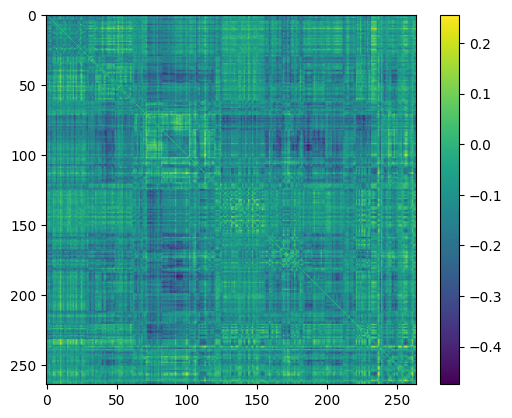

In [3]:
import matplotlib.pyplot as plt

sel = (age > 18)*(sex == 0)*(race == 0)
print(np.sum(sel))
avg1 = np.mean(fc[sel], axis=0)

sel = (age < 10)*(sex == 1)*(race == 1)
print(np.sum(sel))
avg2 = np.mean(fc[sel], axis=0)

plt.imshow(remap(vec2mat(avg1-avg2)))
plt.colorbar()
plt.show()

In [4]:
# Estimate age, sex, race

from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

mage = 10*[None]

for i in range(10):
    xtr, xt, ytr, yt = train_test_split(fc, age, train_size=800)
    mage[i] = Ridge(alpha=1, max_iter=1000).fit(xtr, ytr)
    print(f'Done {i}')

msex = 10*[None]

for i in range(10):
    xtr, xt, ytr, yt = train_test_split(fc, sex, stratify=sex, train_size=200)
    msex[i] = LogisticRegression(C=1, max_iter=500).fit(xtr, ytr)
    print(f'Done {i}')

mrace = 10*[None]

for i in range(10):
    xtr, xt, ytr, yt = train_test_split(fc, race, stratify=race, train_size=200)
    mrace[i] = LogisticRegression(C=1, max_iter=500).fit(xtr, ytr)
    print(f'Done {i}')

Done 0
Done 1
Done 2
Done 3
Done 4
Done 5
Done 6
Done 7
Done 8
Done 9
Done 0
Done 1
Done 2
Done 3
Done 4
Done 5
Done 6
Done 7
Done 8
Done 9
Done 0
Done 1
Done 2
Done 3
Done 4
Done 5
Done 6
Done 7
Done 8
Done 9


In [5]:
wage = mage[1].coef_.squeeze()
bage = mage[1].intercept_

ahat = fc@wage+bage
print(ahat[0:10])
print(age[0:10])

[14.17971709 13.4345111  12.56057053 10.65424891 14.41952763 11.64214533
 14.63537445 15.34520976 15.00466145 19.11732461]
[12 12 12  9  9  9 15 15 15 17]


In [79]:
wsex = msex[0].coef_.squeeze()
bsex = msex[0].intercept_

shat = fc@wsex+bsex
print(shat[0:10])
print(sex[0:10])

[-1.9361777  -1.25202438 -0.98312949 -2.29457346  0.99159158 -2.0227324
 -2.69719172 -0.54780575 -1.92172462  0.19057534]
[1 1 1 0 0 0 0 0 0 1]


In [80]:
wrace = mrace[0].coef_.squeeze()
brace = mrace[0].intercept_

rhat = fc@wrace+brace
print(rhat[0:10])
print(race[0:10])

[ 6.42963264  5.76122658  6.06861813 -4.93193555 -3.47577369 -4.81538452
 -1.46253646 -5.80474168 -5.33377098  2.13892452]
[1 1 1 0 0 0 0 0 0 0]


In [73]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from random import randint

nbasis=5
nsubs=10

def rmse(yt, yhat):
    return torch.mean((yt-yhat)**2)**0.5

class Gen(nn.Module):
    def __init__(self, mage, msex, mrace):
        super(Gen, self).__init__()
        self.wage = []
        self.bage = []
        self.wsex = []
        self.bsex = []
        self.wrace = []
        self.brace = []
#         self.wsz = []
#         self.bsz = []
        for mod in mage:
            self.wage.append(torch.from_numpy(mod.coef_.squeeze()).float().cuda())
            self.bage.append(torch.Tensor([mod.intercept_]).float().cuda())
        for mod in msex:
            self.wsex.append(torch.from_numpy(mod.coef_.squeeze()).float().cuda())
            self.bsex.append(torch.from_numpy(mod.intercept_).float().cuda())
        for mod in mrace:
            self.wrace.append(torch.from_numpy(mod.coef_.squeeze()).float().cuda())
            self.brace.append(torch.from_numpy(mod.intercept_).float().cuda())
#         for mod in msz:
#             self.wsz.append(torch.from_numpy(mod.coef_.squeeze()).float().cuda())
#             self.bsz.append(torch.from_numpy(mod.intercept_).float().cuda())
        self.jitter = nn.Parameter((1/(nbasis*264)**0.5)*torch.randn(264,nbasis).float().cuda())
        self.thetas = nn.Parameter(torch.randn(nbasis,264).float().cuda())
        
    def fcimg(self):
#         t0 = self.thetas.unsqueeze(2)
#         t1 = self.thetas.unsqueeze(1)
#         m = torch.einsum('ab,cb->bac',self.jitter,self.jitter)
#         return torch.mean(m*torch.cos(t0-t1), axis=0)
        return self.jitter@self.jitter.T
    
    def fc(self):
        a,b = torch.triu_indices(264,264,offset=1)
        return self.fcimg()[a,b]
    
    def predict(self, age, sex, race):
        aerr = []
        serr = []
        rerr = []
#         zerr = []
        efc = self.fc()
        for w,b in zip(self.wage, self.bage):
            aerr.append(rmse(age, w@efc+b))
        for w,b in zip(self.wsex, self.bsex):
            serr.append(torch.abs(sex-w@efc+b))
        for w,b in zip(self.wrace, self.brace):
            rerr.append(torch.abs(race-w@efc+b))
#         for w,b in zip(self.wsz, self.bsz):
#             zerr.append(torch.abs(sz-w@efc+b))
        return sum(aerr)/len(aerr), sum(serr)/len(serr), sum(rerr)/len(rerr)#, sum(zerr)/len(zerr)
    
nepochs = 50
pperiod = 100

subj1 = []
subj2 = []

for n in range(nsubs):
    gen = Gen(mage, msex, mrace)
    optim = torch.optim.Adam(gen.parameters(), lr=1e-2, weight_decay=0)

    for epoch in range(nepochs):
        optim.zero_grad()

        fcloss = torch.sum(F.relu(torch.abs(gen.fc())-1))

        aloss, sloss, rloss = gen.predict(18, -20, -20)
        (fcloss+aloss+sloss+rloss).backward()

        optim.step()
        if epoch % pperiod == 0 or epoch == nepochs-1:
            print(f'{epoch} {float(aloss)} {float(sloss)} {float(rloss)}')
            
    subj1.append(gen.fcimg().detach().cpu().numpy())
    
for n in range(nsubs):
    gen = Gen(mage, msex, mrace)
    optim = torch.optim.Adam(gen.parameters(), lr=1e-2, weight_decay=0)

    for epoch in range(nepochs):
        optim.zero_grad()

        fcloss = torch.sum(F.relu(torch.abs(gen.fc())-1))

        aloss, sloss, rloss = gen.predict(10, 20, 20)
        (fcloss+aloss+sloss+rloss).backward()

        optim.step()
        if epoch % pperiod == 0 or epoch == nepochs-1:
            print(f'{epoch} {float(aloss)} {float(sloss)} {float(rloss)}')
            
    subj2.append(gen.fcimg().detach().cpu().numpy())

0 2.7258553504943848 21.871213912963867 14.23706340789795
49 0.2543127238750458 2.571901321411133 1.3162487745285034
0 2.7240962982177734 21.864606857299805 14.239062309265137
49 0.1367197036743164 1.353652834892273 1.2050275802612305
0 2.7313671112060547 21.869436264038086 14.239375114440918
49 0.38472023606300354 3.25628662109375 1.8070999383926392
0 2.7268226146698 21.871788024902344 14.237794876098633
49 0.1963052749633789 2.510594367980957 1.8290328979492188
0 2.7271041870117188 21.868017196655273 14.237126350402832
49 0.31666699051856995 1.599041223526001 1.764571189880371
0 2.733044147491455 21.86800193786621 14.241717338562012
49 0.2101001739501953 2.4680919647216797 1.9663304090499878
0 2.73030161857605 21.872501373291016 14.236587524414062
49 0.13014507293701172 2.177248239517212 1.947266936302185
0 2.723071336746216 21.86496925354004 14.236693382263184
49 0.2986944317817688 1.6728638410568237 1.6460155248641968
0 2.728614330291748 21.868741989135742 14.234756469726562
49 0.2

In [78]:
# Dump weights

wdict = dict(age=mage, sex=msex, race=mrace)
fname = '/home/anton/Documents/Tulane/Research/AngleBasis/data-orig/pnc_gen_model.pkl'

pickle.dump(wdict, open(fname, 'wb'))
print('Complete')

Complete


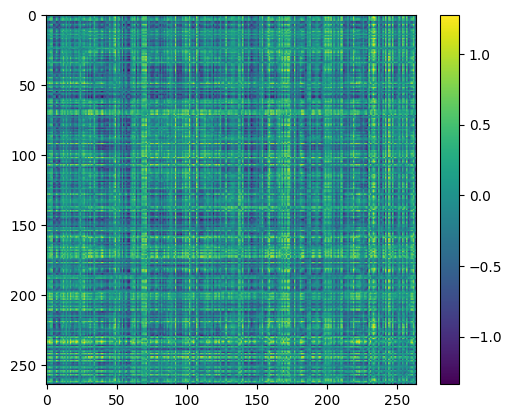

In [74]:
import matplotlib.pyplot as plt

plt.imshow(remap(np.mean(np.stack(subj1), axis=0)-np.mean(np.stack(subj2), axis=0)))
# plt.imshow(remap(subj1[0]))
plt.colorbar()
plt.show()

/tmp/ipykernel_44886/3443669645.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


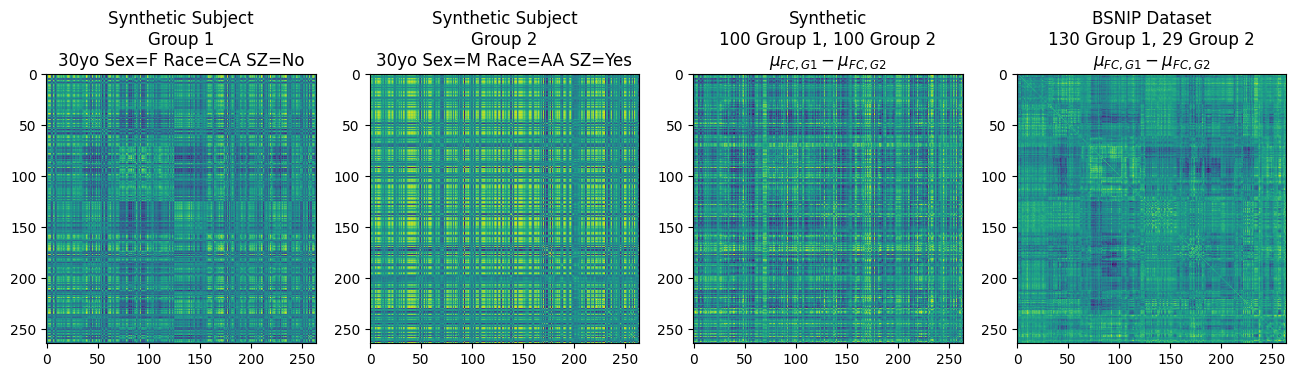

In [75]:
fig, ax = plt.subplots(1,4,figsize=(16,5))

ax[0].imshow(remap(subj1[0]))
ax[0].set_title('Synthetic Subject\nGroup 1\n30yo Sex=F Race=CA SZ=No')

ax[1].imshow(remap(subj2[0]))
ax[1].set_title('Synthetic Subject\nGroup 2\n30yo Sex=M Race=AA SZ=Yes')

ax[2].imshow(remap(np.mean(np.stack(subj1), axis=0)-np.mean(np.stack(subj2), axis=0)))
ax[2].set_title('Synthetic\n100 Group 1, 100 Group 2\n$\mu_{FC,G1}-\mu_{FC,G2}$')

ax[3].imshow(remap(vec2mat(avg1-avg2)))
ax[3].set_title('BSNIP Dataset\n130 Group 1, 29 Group 2\n$\mu_{FC,G1}-\mu_{FC,G2}$')

# fig.savefig('/home/anton/Documents/Tulane/Research/Work/AngleBasis/SyntheticMean.pdf')
fig.show()

/tmp/ipykernel_44886/2295482570.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


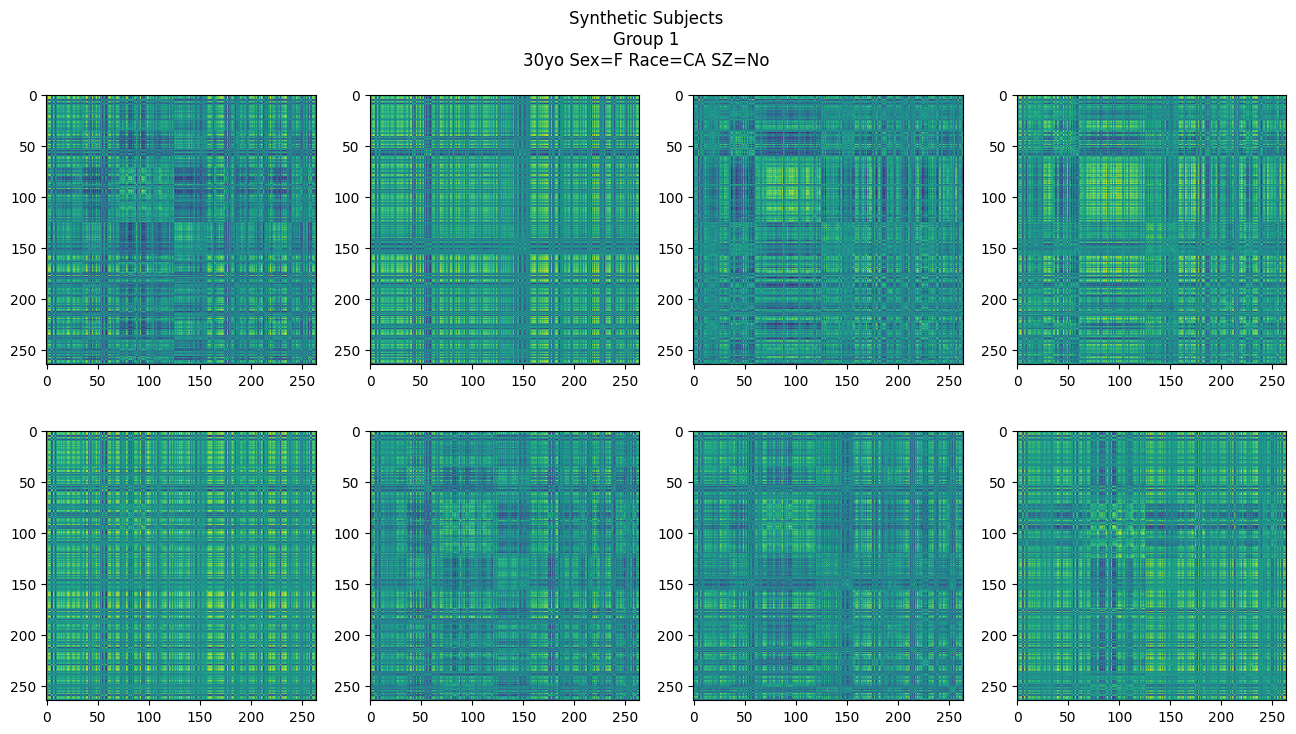

In [76]:
fig, ax = plt.subplots(2,4,figsize=(16,8))

for i in range(2):
    for j in range(4):
        ax[i][j].imshow(remap(subj1[i*4+j]))
        
fig.suptitle('Synthetic Subjects\nGroup 1\n30yo Sex=F Race=CA SZ=No')
# fig.savefig('/home/anton/Documents/Tulane/Research/Work/AngleBasis/SyntheticGroup1.pdf')
fig.show()

/tmp/ipykernel_44886/3975804470.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


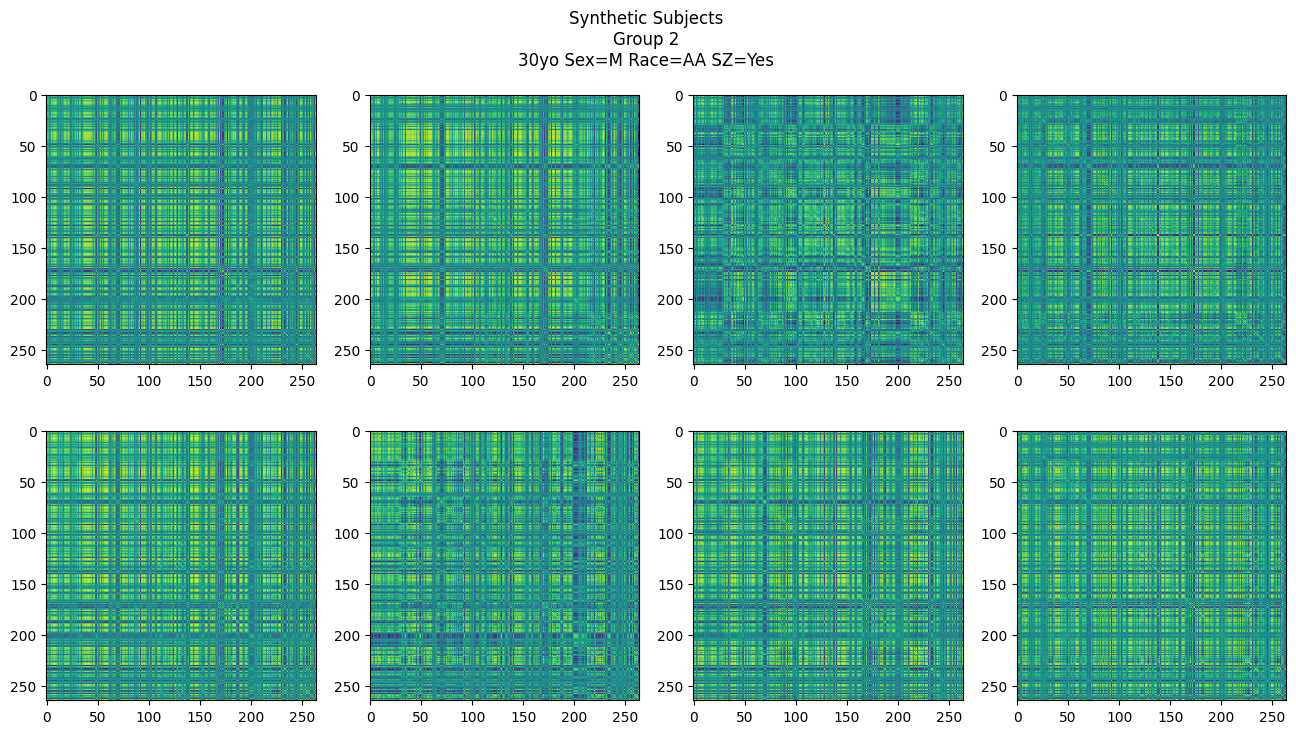

In [77]:
fig, ax = plt.subplots(2,4,figsize=(16,8))

for i in range(2):
    for j in range(4):
        ax[i][j].imshow(remap(subj2[i*4+j]))
        
fig.suptitle('Synthetic Subjects\nGroup 2\n30yo Sex=M Race=AA SZ=Yes')
# fig.savefig('/home/anton/Documents/Tulane/Research/Work/AngleBasis/SyntheticGroup2.pdf')
fig.show()

/tmp/ipykernel_374976/2642766484.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


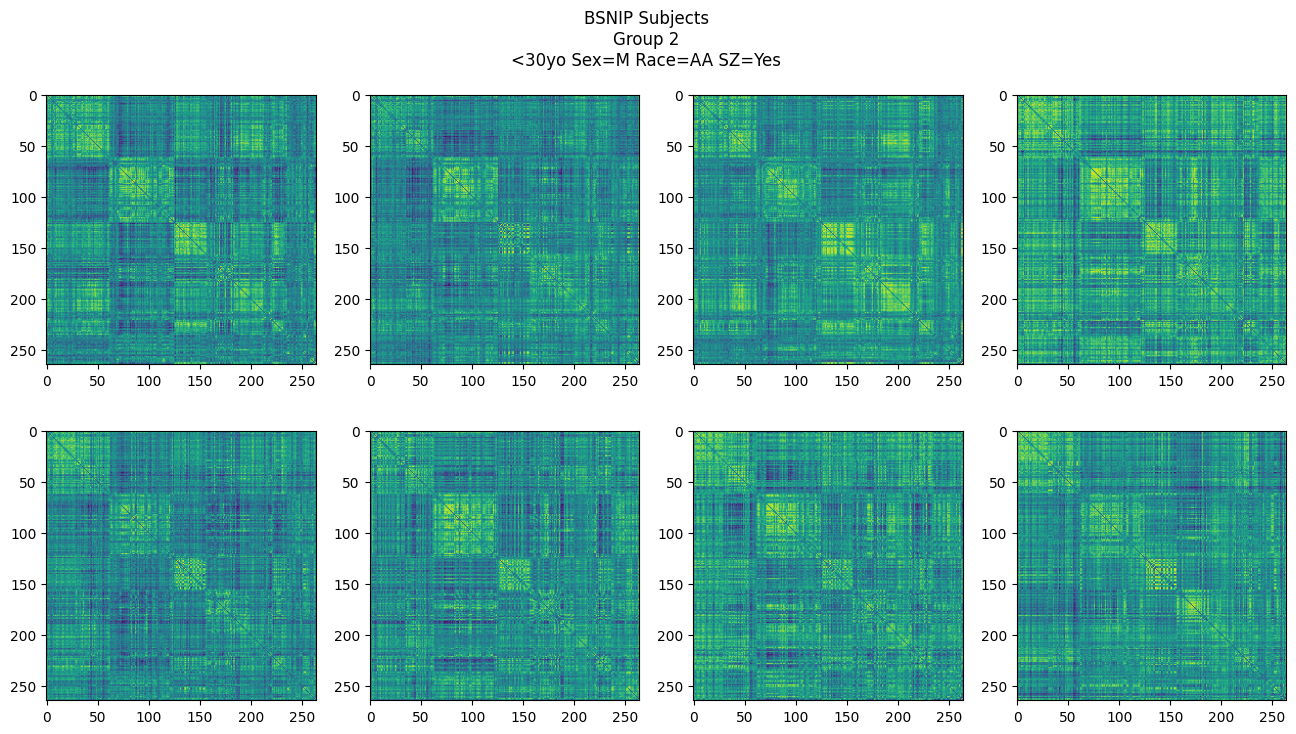

In [29]:
fig, ax = plt.subplots(2,4,figsize=(16,8))

sel = (age > 18)*(sex == 0)*(race == 0)
# sel = (age < 10)*(sex == 1)*(race == 1)
g2 = fc[sel]

for i in range(2):
    for j in range(4):
        ax[i][j].imshow(remap(vec2mat(g2[i*4+j])))
        
# fig.suptitle('BSNIP Subjects\nGroup 1\n<30yo Sex=F Race=CA SZ=No')
fig.suptitle('BSNIP Subjects\nGroup 2\n<30yo Sex=M Race=AA SZ=Yes')
# fig.savefig('/home/anton/Documents/Tulane/Research/Work/AngleBasis/BSNIPGroup2.pdf')
fig.show()

In [185]:
efc = gen.fc().detach().cpu().numpy()
print(efc.shape)

wage = mage.coef_.squeeze()
bage = mage.intercept_

ahat = efc@wage+bage

wsex = msex.coef_.squeeze()
bsex = msex.intercept_

shat = efc@wsex+bsex
print(ahat)
print(age[1])
print(shat)
print(sex[1])

(34716,)
99.34299482797942
53
[-4.93360614]
1
